In [ ]:
import torch
import numpy as np
import pandas as pd
import joblib
from torch.utils.data import DataLoader
from src.data_loader import IMUSeq2SeqDataset
from src.Seq2Seq import Encoder, Decoder, Seq2Seq
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

T_IN   = 24
T_OUT  = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = joblib.load("./Trained_Models/scaler.pkl")

encoder = Encoder(input_dim=6, d_model=128, hidden_dim=128, num_layers = 2)
decoder = Decoder(output_dim=6, hidden_dim=128, num_heads=8, num_layers = 2)
model   = Seq2Seq(encoder, decoder, teacher_forcing=0.0, pred_steps=T_OUT).to(DEVICE) 
model.load_state_dict(torch.load("./Trained_Models/best_seq2seq_model.pt", map_location=DEVICE))
model.eval()

print("Model and scaler loaded.")

def load_and_preprocess_csv(file_path, window_size=36, stride=6):
    df = pd.read_csv(file_path)
    data = df[["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]].values

    windows = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start+window_size]
        windows.append(window)

    if len(windows) == 0:
        raise ValueError("Not enough data to form one window.")

    windows = np.stack(windows)
    # Apply same global scaler
    N, T, C = windows.shape
    windows_norm = scaler.transform(windows.reshape(-1, C)).reshape(N, T, C)
    return windows_norm

def predict_on_file(file_path):
    windows_norm = load_and_preprocess_csv(file_path)

    dataset = IMUSeq2SeqDataset(windows_norm, t_in=T_IN, t_out=T_OUT,
                                normalize=False, mean_removal=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    preds_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            pred, _ = model(xb)  # (1, T_OUT, C)
            pred = pred.cpu().numpy()
            preds_all.append(pred)

    preds_all = np.concatenate(preds_all, axis=0)  # (N, T_OUT, C)
    
    # Denormalize back to real values
    N, T, C = preds_all.shape
    preds_denorm = scaler.inverse_transform(preds_all.reshape(-1, C)).reshape(N, T, C)

    return preds_denorm

def predict_and_evaluate(file_path):

    windows_norm = load_and_preprocess_csv(file_path)

    dataset = IMUSeq2SeqDataset(
        windows_norm, t_in=T_IN, t_out=T_OUT,
        normalize=False, mean_removal=False
    )
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    preds_all, trues_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred, _ = model(xb)  # (1, T_OUT, C)

            preds_all.append(pred.cpu().numpy())
            trues_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all, axis=0) 
    trues_all = np.concatenate(trues_all, axis=0)
    print("Scaler mean:", scaler.mean_)
    print("Eval data mean:", np.mean(windows_norm.reshape(-1,6), axis=0))

    N, T, C = preds_all.shape
    # preds_denorm = scaler.inverse_transform(preds_all.reshape(-1, C)).reshape(N, T, C)
    # trues_denorm = scaler.inverse_transform(trues_all.reshape(-1, C)).reshape(N, T, C)
    pred_mean = preds_denorm[..., 0].mean()
    true_mean = trues_denorm[..., 0].mean()
    print(f"Pred mean: {pred_mean:.2f}, True mean: {true_mean:.2f}, Difference: {pred_mean - true_mean:.2f}")
   
    mse = mean_squared_error(trues_denorm.reshape(-1, C), preds_denorm.reshape(-1, C))
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_denorm.reshape(-1, C), preds_denorm.reshape(-1, C))

    print(f"Evaluation on {file_path}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    i, ch = 0, 0
    plt.figure(figsize=(8,4))
    plt.plot(trues_denorm[i,:,ch], label="True")
    plt.plot(preds_denorm[i,:,ch], label="Pred", linestyle="--")
    plt.title(f"Prediction vs True (sample {i}, channel {ch})")
    plt.xlabel("Time step")
    plt.ylabel("Sensor value")
    plt.legend()
    plt.show()

    return preds_denorm, trues_denorm

if __name__ == "__main__":
    file_path = "snaptic_log_20250923_132559.csv"
    preds, trues = predict_and_evaluate(file_path)


C:\Users\ammou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model and scaler loaded.
Scaler mean: [ 2.71682899e+00  4.52007802e+01  9.11776153e-01 -1.22947979e-01
  6.00180768e+02  1.13402365e+01]
Eval data mean: [-0.09860125 -0.12991386  0.00245524 -0.04651654 -0.2179285   0.0287474 ]
Pred mean: -0.09, True mean: -0.09, Difference: -0.00


NameError: name 'trues_denorm' is not defined

Scaler mean: [ 2.71682899e+00  4.52007802e+01  9.11776153e-01 -1.22947979e-01
  6.00180768e+02  1.13402365e+01]
Eval data mean: [-0.09860125 -0.12991386  0.00245524 -0.04651654 -0.2179285   0.0287474 ]
Pred mean: -5.18, True mean: -5.00, Difference: -0.17
Evaluation on snaptic_log_20250923_132559.csv
MSE:  1934.9484
RMSE: 43.9880
R²:   0.9952


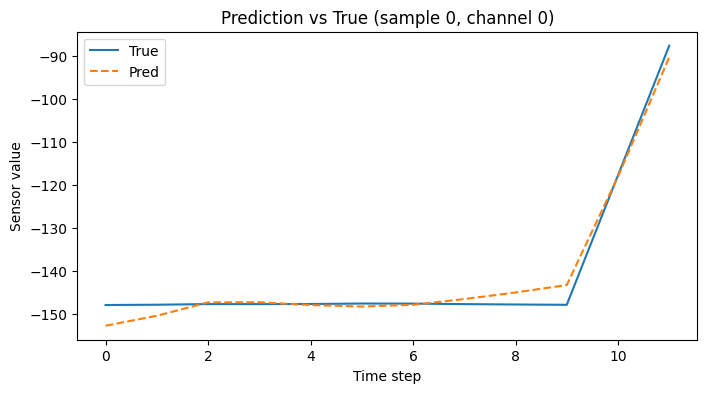

Scaler mean: [ 2.71682899e+00  4.52007802e+01  9.11776153e-01 -1.22947979e-01
  6.00180768e+02  1.13402365e+01]


NameError: name 'data' is not defined

C:\Users\ammou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Model and scaler loaded.
Scaler mean: [ 2.71682899e+00  4.52007802e+01  9.11776153e-01 -1.22947979e-01
  6.00180768e+02  1.13402365e+01]
Eval data mean: [-0.09860125 -0.12991386  0.00245524 -0.04651654 -0.2179285   0.0287474 ]
Pred mean (norm): -0.09, True mean (norm): -0.09, Diff: -0.00
Evaluation on snaptic_log_20250923_132559.csv
Normalized MSE:  0.0033
Normalized RMSE: 0.0574
Normalized R²:   0.9952


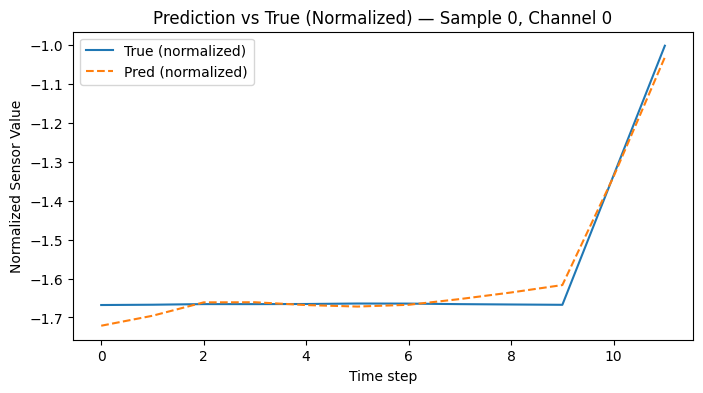

In [ ]:
import torch
import numpy as np
import pandas as pd
import joblib
from torch.utils.data import DataLoader
from src.data_loader import IMUSeq2SeqDataset
from src.Seq2Seq import Encoder, Decoder, Seq2Seq
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

T_IN   = 24
T_OUT  = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = joblib.load("./Trained_Models/scaler.pkl")

encoder = Encoder(input_dim=6, d_model=128, hidden_dim=128, num_layers=2)
decoder = Decoder(output_dim=6, hidden_dim=128, num_heads=8, num_layers=2)
model   = Seq2Seq(encoder, decoder, teacher_forcing=0.0, pred_steps=T_OUT).to(DEVICE)
model.load_state_dict(torch.load("./Trained_Models/best_seq2seq_model.pt", map_location=DEVICE))
model.eval()

print("✅ Model and scaler loaded.")

def load_and_preprocess_csv(file_path, window_size=36, stride=6):
    df = pd.read_csv(file_path)
    data = df[["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]].values

    windows = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start + window_size]
        windows.append(window)

    if len(windows) == 0:
        raise ValueError("Not enough data to form one window.")

    windows = np.stack(windows)
    # Apply global scaler normalization
    N, T, C = windows.shape
    windows_norm = scaler.transform(windows.reshape(-1, C)).reshape(N, T, C)
    return windows_norm

def predict_and_evaluate(file_path):
    windows_norm = load_and_preprocess_csv(file_path)

    dataset = IMUSeq2SeqDataset(
        windows_norm, t_in=T_IN, t_out=T_OUT,
        normalize=False, mean_removal=False
    )
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    preds_all, trues_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred, _ = model(xb)  # (1, T_OUT, C)
            preds_all.append(pred.cpu().numpy())
            trues_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all, axis=0)
    trues_all = np.concatenate(trues_all, axis=0)

    print("Scaler mean:", scaler.mean_)
    print("Eval data mean:", np.mean(windows_norm.reshape(-1, 6), axis=0))

    N, T, C = preds_all.shape

    pred_mean = preds_all[..., 0].mean()
    true_mean = trues_all[..., 0].mean()
    print(f"Pred mean (norm): {pred_mean:.2f}, True mean (norm): {true_mean:.2f}, "
          f"Diff: {pred_mean - true_mean:.2f}")

    mse = mean_squared_error(trues_all.reshape(-1, C), preds_all.reshape(-1, C))
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_all.reshape(-1, C), preds_all.reshape(-1, C))

    print(f"Evaluation on {file_path}")
    print(f"Normalized MSE:  {mse:.4f}")
    print(f"Normalized RMSE: {rmse:.4f}")
    print(f"Normalized R²:   {r2:.4f}")

    i, ch = 0, 0
    plt.figure(figsize=(8, 4))
    plt.plot(trues_all[i, :, ch], label="True (normalized)")
    plt.plot(preds_all[i, :, ch], label="Pred (normalized)", linestyle="--")
    plt.title(f"Prediction vs True (Normalized) — Sample {i}, Channel {ch}")
    plt.xlabel("Time step")
    plt.ylabel("Normalized Sensor Value")
    plt.legend()
    plt.show()

    # Return normalized outputs
    return preds_all, trues_all

if __name__ == "__main__":
    file_path = "snaptic_log_20250923_132559.csv"
    preds, trues = predict_and_evaluate(file_path)
